<a href="https://colab.research.google.com/github/gkanfer/SpatialOmicsToolkit/blob/main/simulate_celltype_distance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pymc
!pip install scanpy -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.9/169.9 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.4/255.4 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 116.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 2.7 MB/s eta 0:00:00


In [2]:
! pip install git+https://github.com/pymc-devs/pymc-extras -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.6/517.6 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 5.4 MB/s eta 0:00:00


In [8]:
import pymc_extras as pmx

In [9]:
import scanpy as sc

In [12]:
import pymc as pm
import numpy as np
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

In [13]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [14]:
cd '/content/drive/MyDrive/Data/andata'

/content/drive/MyDrive/Data/andata


In [15]:
andata = sc.read_h5ad("andata_sim.h5ad")

In [16]:
andata.obs['labels'] = andata.obs['labels_author_3'].astype(str)
A = andata[andata.obs['labels']=='Endothelial cells'].obsm['spatial'].copy()

In [17]:
B = andata[andata.obs['labels']!='Endothelial cells'].obsm['spatial'].copy() # random points

<div><center>One group simulation</center></div>
<div>Based on this idea:<div>

Short answer: Categorical is exactly what you want—for the **mode** choice. You still have one biological “target group,” but you’re modeling **three spatial modes** of how that group sits around anchors. Use a discrete mode label for each simulated cell, then draw its radial distance and angle from mode-specific distributions.

Here’s the clean math + a tiny NumPy/SciPy simulator you can drop in.

# Math (generative model)

* Anchors: $A=\{a_j\}_{j=1}^{N_A},\ a_j\in\mathbb R^2$ (fixed from data)
* Modes: $k\in\{1,2,3\}$ with $\boldsymbol\pi=(0.1,0.4,0.5)$
* For $i=1,\dots,N$ (here $N=100$):

  1. **Mode** $m_i \sim \mathrm{Categorical}(\boldsymbol\pi)$
  2. **Radius** $r_i \mid m_i \sim \mathrm{TruncNormal}_{[0,\infty)}\!\big(\mu_{m_i},\sigma_{m_i}^2\big)$
     (or Gamma/LogNormal if you prefer positive-only without truncation)
  3. **Angle** $\theta_i \sim \mathrm{Uniform}(0,2\pi)$
  4. **Anchor pick** $a_i \sim \mathrm{Uniform}\{1,\dots,N_A\}$ (or density-weighted)
  5. **Coordinates** $t_i = a_{a_i} + \big(r_i\cos\theta_i,\ r_i\sin\theta_i\big)$

Notes:

* Your “$z_i=1$” can remain the **group** label; just introduce a separate **mode** label $m_i$.
* Calibrate $\mu_k,\sigma_k$ from your **empirical distance transform**: compute all non-anchor distances to the nearest anchor and set, e.g.,
  $\mu_{\text{near}}\approx$ 10th–20th percentile, $\mu_{\text{mid}}\approx$ 40th–60th, $\mu_{\text{far}}\approx$ 80th–90th; set $\sigma_k$ to a fraction of $d_{\max}$ or the local MAD.



In [ ]:
MU = [3,50,80]
sig = [0.5,3,5]
pi = [0.1,0.3,0.6]
m = pm.draw(pm.Categorical.dist(pi),500,random_seed=RANDOM_SEED)
th = pm.draw(pm.Uniform.dist(0,2*np.pi),500,random_seed=RANDOM_SEED)
a = pm.draw(pm.Uniform.dist(0,A.shape[0]),500,random_seed=RANDOM_SEED).astype(int)

In [ ]:
b = np.zeros((500,2))
for i in range(500):
  r = pm.draw(pm.TruncatedNormal.dist(mu = MU[m[i]], sigma = sig[m[i]],lower = 0.5,upper = 100),1,random_seed=RANDOM_SEED)
  t = A[a[i]] + (r*np.cos(th[i]),r*np.sin(th[i]))
  b[i,0],b[i,1] = t[0],t[1]

In [ ]:
import pickle
with open("one_group_distance_sim.pkl", "wb") as f:
    pickle.dump(b, f)

<div><center>Multiple group simulation</center></div>:

In [ ]:
from tqdm import tqdm
MU = ([[3,50,80],[3,50,80],[3,50,80],[3,21,6.3]])
sig = ([[100,100,100],[100,100,100],[100,100,100],[100,100,100]])
pi = ([[0.1,0.3,0.6],[0.01,0.5,0.49],[0.1,0.3,0.6],[0.05,0.4,0.1]])
N = [5000,10,10,5000]
name = ['A','B','C','D']
simulation_set = {}
for i,n in enumerate(N):
  b = np.zeros((n,2))
  MU_ = MU[i]
  sig_ = sig[i]
  pi_ = pi[i]
  m = pm.draw(pm.Categorical.dist(pi_),n,random_seed=RANDOM_SEED)
  th = pm.draw(pm.Uniform.dist(0,2*np.pi),n,random_seed=RANDOM_SEED)
  a = pm.draw(pm.Uniform.dist(0,A.shape[0]),n,random_seed=RANDOM_SEED).astype(int)
  for j in tqdm(range(n)):
    r = pm.draw(pm.TruncatedNormal.dist(mu = MU_[m[j]], sigma = sig_[m[j]],lower = 0.5,upper = 100),1,random_seed=RANDOM_SEED)
    th = pm.draw(pm.Uniform.dist(0,2*np.pi),2,random_seed=RANDOM_SEED)
    t = A[a[j]] + (r*np.cos(th[0]),r*np.sin(th[1]))
    b[j,0],b[j,1] = t[0],t[1]
  simulation_set[name[i]] = b
  print(f'done {name[i]}')



100%|██████████| 5000/5000 [01:43<00:00, 48.47it/s]


done A


100%|██████████| 10/10 [00:00<00:00, 65.62it/s]


done B


100%|██████████| 10/10 [00:00<00:00, 63.28it/s]
/usr/local/lib/python3.11/dist-packages/pymc/distributions/discrete.py:1142: UserWarning: `p` parameters sum to [0.55], instead of 1.0. They will be automatically rescaled. You can rescale them directly to get rid of this warning.
  warnings.warn(


done C


100%|██████████| 5000/5000 [01:37<00:00, 51.24it/s]

done D


In [ ]:
pm.find_constrained_prior(
    pm.Gamma,
    lower = 2, upper = 70,
    mass=0.6,
    init_guess={"alpha": 3, "beta": 0.1}
)

/tmp/ipython-input-904178786.py:1: FutureWarning: find_constrained_prior is deprecated and will be removed in a future version. Please use maxent function from PreliZ. https://preliz.readthedocs.io/en/latest/api_reference.html#preliz.unidimensional.maxent
  pm.find_constrained_prior(


{'alpha': np.float64(3.000759794079963),
 'beta': np.float64(0.044381414190217766)}

<Axes: >

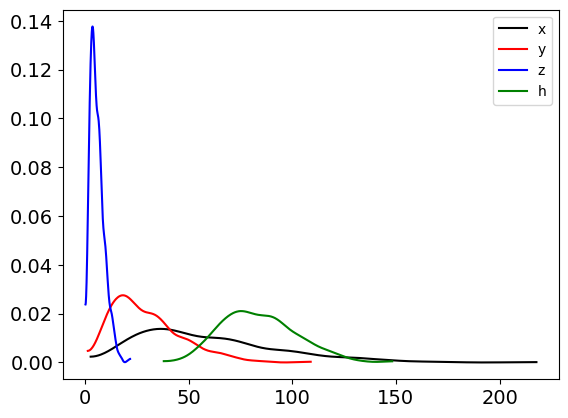

In [ ]:
import seaborn as sns
import arviz as az
palette1 = sns.color_palette("colorblind",4)
x = pm.draw(pm.Gamma.dist(alpha = 3, beta = 0.05),1000,random_seed=RANDOM_SEED)
y = pm.draw(pm.Gamma.dist(alpha = 3, beta = 0.1),1000,random_seed=RANDOM_SEED)
z = pm.draw(pm.Gamma.dist(alpha = 3, beta = 0.5),1000,random_seed=RANDOM_SEED)
h = pm.draw(pm.Gamma.dist(alpha = 21, beta = 0.25),1000,random_seed=RANDOM_SEED)
az.plot_kde(
    x,plot_kwargs={"color": "black", "label":"x"},
)
az.plot_kde(
    y,plot_kwargs={"color": "red", "label":"y"},
)
az.plot_kde(
    z,plot_kwargs={"color": "blue", "label":"z"},
)
az.plot_kde(
    h,plot_kwargs={"color": "green", "label":"h"},
)

In [ ]:
AB = andata.obsm['spatial']
mask_endo = andata.obs['labels'] == 'Endothelial cells'
idx_endo = np.where(mask_endo)[0]
mask_reset = andata.obs['labels'] != 'Endothelial cells'
idx_reset = np.where(mask_reset)[0]

In [ ]:
from tqdm import tqdm
target_number_list = [100,100,100,100]
alpha = ([[3,3,3],[3,3,3],[3,3,3],[21,3,3]])
beta = ([[0.05,0.1,0.5],[0.05,0.1,0.5],[0.05,0.1,0.5],[0.25,0.05,0.5]])
pi = ([[0.1,0.1,0.8],[0.01,0.5,0.49],[0.1,0.8,0.1],[0.48,0.2,0.48]])
N = [1000,1000,1000,1000]
name = ['A','B','C','D']
simulation_set = {}
for i,n in enumerate(N):
  b = np.zeros((n,2))
  a_ = alpha[i]
  b_ = beta[i]
  pi_ = pi[i]
  m = pm.draw(pm.Categorical.dist(pi_),n,random_seed=RANDOM_SEED)
  target_number = target_number_list[i]
  if target_number > n:
    a = pm.draw(pm.Categorical.dist(p=np.ones(len(idx_endo)) / len(idx_endo)),n,random_seed=RANDOM_SEED).astype(int)
  else:
    a_sel = pm.draw(pm.Categorical.dist(p=np.ones(len(idx_endo)) / len(idx_endo)),target_number,random_seed=RANDOM_SEED).astype(int)
    b_sel = pm.draw(pm.Categorical.dist(p=np.ones(len(idx_reset)) / len(idx_reset)),n-target_number,random_seed=RANDOM_SEED).astype(int)
    a = np.concatenate((a_sel,b_sel))
  th = pm.draw(pm.Uniform.dist(0,2*np.pi),n,random_seed=RANDOM_SEED)
  for j in tqdm(range(n)):
    r = pm.draw(pm.Gamma.dist(alpha = a_[m[j]], beta = b_[m[j]]),1,random_seed=RANDOM_SEED)
    # th = pm.draw(pm.Uniform.dist(0,2*np.pi),2,random_seed=RANDOM_SEED)
    t = AB[a[j]] + (r*np.cos(th[j]),r*np.sin(th[j]))
    b[j,0],b[j,1] = t[0],t[1]
  simulation_set[name[i]] = b
  print(f'done {name[i]}')




100%|██████████| 1000/1000 [00:10<00:00, 91.15it/s]


done A


100%|██████████| 1000/1000 [00:11<00:00, 89.96it/s]


done B


100%|██████████| 1000/1000 [00:11<00:00, 88.48it/s]
/usr/local/lib/python3.11/dist-packages/pymc/distributions/discrete.py:1142: UserWarning: `p` parameters sum to [1.16], instead of 1.0. They will be automatically rescaled. You can rescale them directly to get rid of this warning.
  warnings.warn(


done C


100%|██████████| 1000/1000 [00:11<00:00, 87.94it/s]

done D


<div><center>Multiple group simulation Log naormal</center></div>:

(0.0, 100.0)

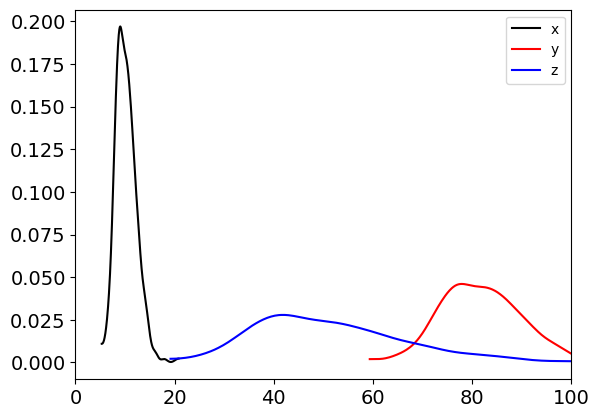

In [ ]:
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
palette1 = sns.color_palette("colorblind",4)
x = pm.draw(pm.LogNormal.dist(mu = 2.3, sigma = 0.2),1000,random_seed=RANDOM_SEED)
y = pm.draw(pm.LogNormal.dist(mu = 4.4, sigma = 0.1),1000,random_seed=RANDOM_SEED)
z = pm.draw(pm.LogNormal.dist(mu = 3.9, sigma = 0.3),1000,random_seed=RANDOM_SEED)
az.plot_kde(
    x,plot_kwargs={"color": "black", "label":"x"},
)
az.plot_kde(
    y,plot_kwargs={"color": "red", "label":"y"},
)
az.plot_kde(
    z,plot_kwargs={"color": "blue", "label":"z"},
)
plt.xlim(0,100)

In [18]:
AB = andata.obsm['spatial']
mask_endo = andata.obs['labels'] == 'Endothelial cells'
idx_endo = np.where(mask_endo)[0]
mask_reset = andata.obs['labels'] != 'Endothelial cells'
idx_reset = np.where(mask_reset)[0]

In [118]:
from tqdm import tqdm
target_number_list = [207,5,207]
MU = ([[2.3,4.4],[2.3,4.4],[2.3,4.4]])
sig = ([[0.1,0.1],[0.1,0.1],[0.1,0.1]])
pi = ([[0.95,0.5],[0.5,0.5],[0.5,0.5]])
N = [200,200,200]
name = ['A','B','C']
simulation_set = {}
for i,n in enumerate(N):
  b = np.zeros((n,2))
  MU_ = MU[i]
  sig_ = sig[i]
  pi_ = pi[i]
  m = pm.draw(pm.Categorical.dist(pi_),n,random_seed=RANDOM_SEED)
  target_number = target_number_list[i]
  if target_number > n:
    a = pm.draw(pm.Categorical.dist(p=np.ones(len(idx_endo)) / len(idx_endo)),n,random_seed=RANDOM_SEED).astype(int)
  else:
    a_sel = pm.draw(pm.Categorical.dist(p=np.ones(len(idx_endo)) / len(idx_endo)),target_number,random_seed=RANDOM_SEED).astype(int)
    b_sel = pm.draw(pm.Categorical.dist(p=np.ones(len(idx_reset)) / len(idx_reset)),n-target_number,random_seed=RANDOM_SEED).astype(int)
    a = np.concatenate((a_sel,b_sel))
  th = pm.draw(pm.Uniform.dist(0,2*np.pi),n,random_seed=RANDOM_SEED)
  for j in tqdm(range(n)):
    r = pm.draw(pm.LogNormal.dist(mu = MU_[m[j]], sigma = sig_[m[j]]),1,random_seed=RANDOM_SEED)
    # th = pm.draw(pm.Uniform.dist(0,2*np.pi),2,random_seed=RANDOM_SEED)
    t = AB[a[j]] + (r*np.cos(th[j]),r*np.sin(th[j]))
    b[j,0],b[j,1] = t[0],t[1]
  simulation_set[name[i]] = b
  print(f'done {name[i]}')



/usr/local/lib/python3.11/dist-packages/pymc/distributions/discrete.py:1142: UserWarning: `p` parameters sum to [1.45], instead of 1.0. They will be automatically rescaled. You can rescale them directly to get rid of this warning.
  warnings.warn(
100%|██████████| 200/200 [00:01<00:00, 143.17it/s]


done A


100%|██████████| 200/200 [00:01<00:00, 138.49it/s]


done B


100%|██████████| 200/200 [00:01<00:00, 114.22it/s]

done C


In [119]:
import pickle
with open("multi_group_distance_sim_logNorm.pkl", "wb") as f:
    pickle.dump(simulation_set, f)

<center>Model Analysis logNorm</center>

In [120]:
import pickle
import os
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import re
import random
from scipy import ndimage as ndi
import seaborn as sns


In [121]:
def create_2darr(x, y, binarr):
    # Convert coordinates to integers
    x = x.astype(int)
    y = y.astype(int)

    height = int(np.ceil(y.max())) + 1
    width = int(np.ceil(x.max())) + 1

    image = np.zeros((height, width), dtype=int)
    image[y, x] = binarr  # Use the correct variable name
    return image
def Arr2dTo1d_arr(XY,dist_arr):
    XY = XY.astype(int)
    x, y = XY[:, 0], XY[:, 1]
    dist_col = dist_arr[y, x]
    return dist_col

In [122]:
andata = sc.read_h5ad("andata_sim.h5ad")
with open("multi_group_distance_sim_logNorm.pkl", "rb") as f: #multi_group_distance_sim.pkl
  multi_object_dict = pickle.load(f)

In [123]:
arr_list = []
arr_list.append(andata.obsm['spatial'])

key_list = []
key_list.append(['anchor']*andata.obsm['spatial'].shape[0])

for i,key in enumerate(multi_object_dict.keys()):
    new_coords = multi_object_dict[key]
    arr_list.append(new_coords)
    key_list.append([f'target_{i}']*new_coords.shape[0])

In [124]:
from itertools import chain
flat_key_list = list(chain.from_iterable(key_list))
flat_arr = np.vstack(arr_list)
df = pd.DataFrame({'label':flat_key_list})

In [125]:
endo_bin = np.where(df['label'].values=='anchor',1,0).astype(int)
endo_bin_bin = create_2darr(x =flat_arr[:,0],y = flat_arr[:,1],binarr = endo_bin)
dist_to_endo = ndi.distance_transform_edt(endo_bin_bin == 0)
df['endo_distance'] = Arr2dTo1d_arr(XY = flat_arr,dist_arr = dist_to_endo)

In [126]:
df_fin = df.loc[df['label']!='anchor'].copy()
df_fin['endo_distance_log'] = np.log(df_fin['endo_distance'])

In [127]:
df_fin.groupby('label').agg(
        mean_dis_total_exp=("endo_distance_log", "mean"),
        max_dis_total_exp=("endo_distance_log", "max"),
        std=("endo_distance_log", "std"),
        c = ('label','count'))

,mean_dis_total_exp,max_dis_total_exp,std,c
label,,,,
target_0,1.931969,4.013085,0.662070,200
target_1,1.803418,4.265449,0.857317,200
target_2,2.012030,4.115289,0.704863,200


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid

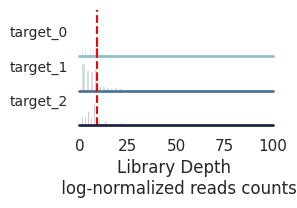

In [130]:
import seaborn as sns
unique_batches_numpy = pd.unique(df_fin['label'])
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Define palette
pal = sns.cubehelix_palette(len(unique_batches_numpy), rot=-.25, light=.7)

# Initialize FacetGrid
g = sns.FacetGrid(df_fin, row="label", hue="label", aspect=5, height=.5, palette=pal)

# Draw the densities
# g.map(sns.kdeplot, "endo_distance", bw_adjust=0.01, clip_on=False, fill=True, alpha=1, linewidth=1.5)
# g.map(sns.kdeplot, "endo_distance", clip_on=False, color="w", lw=2, bw_adjust=0.01)

g.map(sns.histplot, "endo_distance", alpha=1, linewidth=1.5)
g.map(sns.histplot, "endo_distance", color="w", )

def add_mean_line(**kwargs):
    mean_value = np.round(np.mean(df_fin['endo_distance'].values),0)
    plt.axvline(mean_value, color='red', linestyle='--', linewidth=1.5)

g.map(add_mean_line)
# Add a reference line
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-0.25)

# Limit the x-axis
g.set(xlim=(0, 50))

g.set_titles("")

# Change x-axis label
g.set_axis_labels("Library Depth \n log-normalized reads counts", None)

# Properly align batch labels on the y-axis
for ax, label in zip(g.axes.flat, unique_batches_numpy):
    ax.set_ylabel(f"{label}", rotation=0, ha='left', va='center', labelpad=50,fontsize = 10)

# Remove unnecessary plot details
g.set(yticks=[])
g.despine(bottom=True, left=True)

# Show plot
plt.show()

In [63]:
groups = ['target_0', 'target_1', 'target_2']
y = [df_fin.loc[df_fin['label']==g, 'endo_distance_log'].to_numpy() for g in groups]

In [ ]:
np.shape(y)

(3, 1000)

In [64]:
r = df_fin.endo_distance_log.values
r_bar = np.mean(r)
s_bar = np.std(r)
G, K = 3, 2
ind_label, label_coor = df_fin.label.factorize()
coords = {'K':np.arange(2),'G':np.arange(3)}

In [95]:
with pm.Model(coords = coords) as logN_model:
  mu = pm.Normal("mu",r_bar,s_bar,dims = ("G","K"),transform=pm.distributions.transforms.Ordered())
  sigma = pm.InverseGamma("sigma",alpha = 2,beta = 1,dims = ("G","K"))
  Weights = pm.Dirichlet("Weights",a = np.ones((G,K)),dims = ("G","K"))
  #obs = pm.NormalMixture('obs',w = Weights[ind_label,None],mu = mu[ind_label,None],sigma = sigma[ind_label,None],observed = r[:,None])
  obs = pm.NormalMixture('obs',w = Weights[ind_label],mu = mu[ind_label],sigma = sigma[ind_label],observed = r)

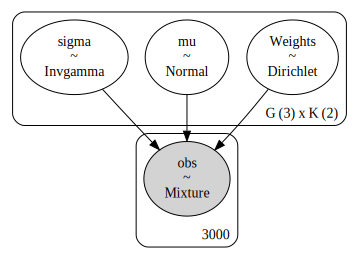

In [96]:
pm.model_to_graphviz(logN_model)

In [97]:
# r is df_fin.endo_distance_log; groups are in df_fin['label']
stats = df_fin.groupby('label')['endo_distance_log'].agg(['mean','std']).reindex(label_coor)
m = stats['mean'].to_numpy()           # shape (G,)
s = np.clip(stats['std'].to_numpy(), 1e-3, None)  # avoid zeros

# Two components per group (K=2): put them around the group mean and keep them ordered
mu0 = np.column_stack([m - 0.5*s, m + 0.5*s])     # shape (G, K), strictly increasing across K

# Reasonable positive scales near the empirical spread
sigma0 = np.column_stack([0.8*s, 1.2*s])          # shape (G, K), > 0

# Mildly informative, not extreme mixing weights
W0 = np.tile(np.array([0.6, 0.4]), (G, 1))        # shape (G, K); rows sum to 1

initvals = dict(mu=mu0, sigma=sigma0, Weights=W0)


In [98]:
mu0 = pm.draw(pm.Normal.dist(mu = [0.5,3],sigma = 0.2),3,random_seed=RANDOM_SEED)
W0 = np.tile(np.array([0.6, 0.4]), (G, 1))
initvals = dict(mu=mu0, Weights=W0)

In [99]:
with logN_model:
  idata_ref = pm.sample(target_accept=0.98, random_seed=123,initvals = initvals)

/usr/local/lib/python3.11/dist-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


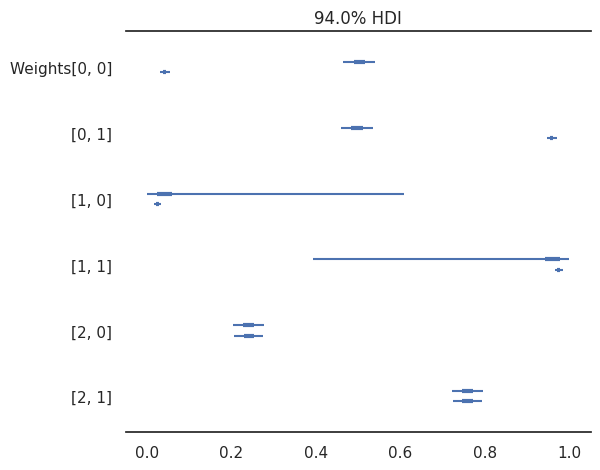

In [100]:
az.plot_forest(idata_ref, var_names="Weights");

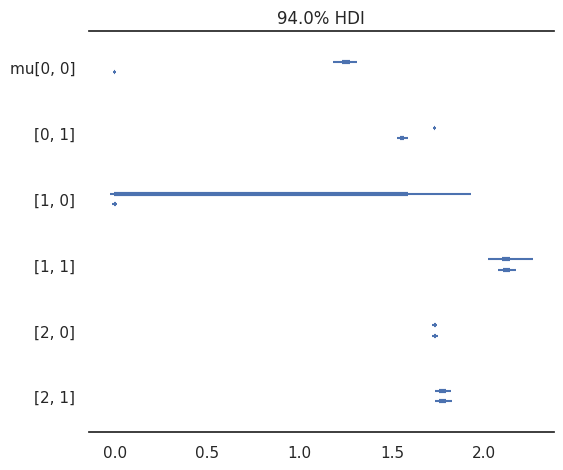

In [101]:
az.plot_forest(idata_ref, var_names="mu");

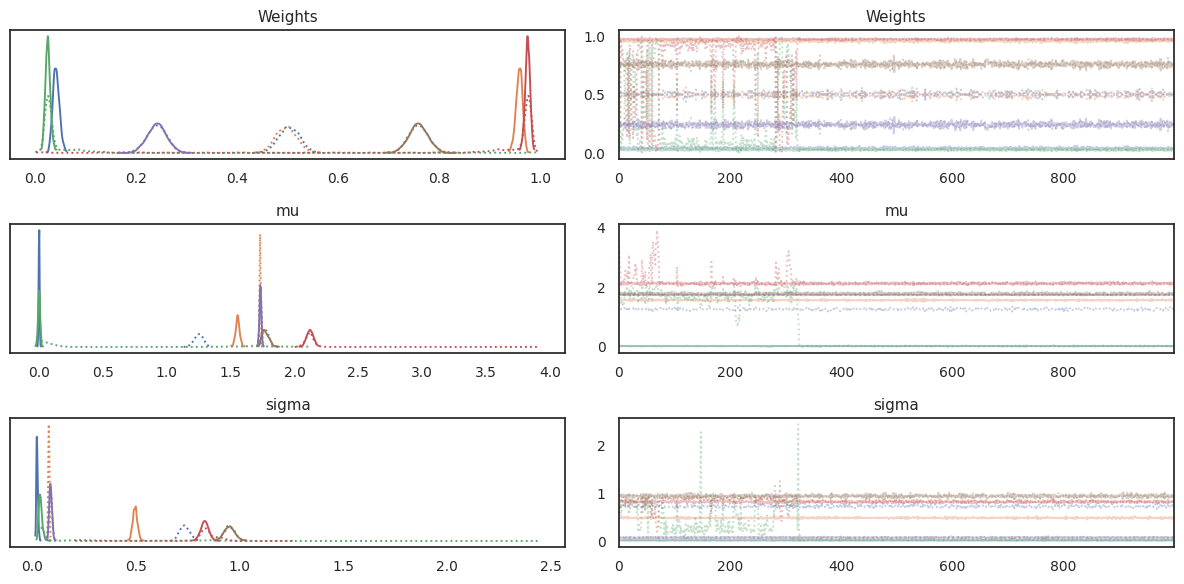

In [102]:
az.plot_trace(idata_ref)
plt.tight_layout();

In [103]:
with logN_model:
    idata_path = pmx.fit(
        method="pathfinder",
        jitter=1,
        num_draws=2000,
        random_seed=123,
        initvals = initvals
    )

Output()

Pathfinder Results                           
                                             
  No. model parameters     15                
                                             
  Configuration:                             
  num_draws_per_path       1000              
  history size (maxcor)    9                 
  max iterations           1000              
  ftol                     1.00e-05          
  gtol                     1.00e-08          
  max line search          1000              
  jitter                   1                 
  epsilon                  1.00e-08          
  ELBO draws               10                
                                             
  LBFGS Status:                              
  CONVERGED                4                 
  L-BFGS iterations        mean 57 ± std 31  
                                             
  Path Status:                               
  SUCCESS                  4                 
  ELBO argmax              mean 48 ± std 26  
                                             
  Importance Sampling:                       
  Method                   psis              
  Pareto k                 3.83              
                                             
  Timing (seconds):                          
  Compile                  11.80             
  Compute                  7.28              
  Total                    19.08

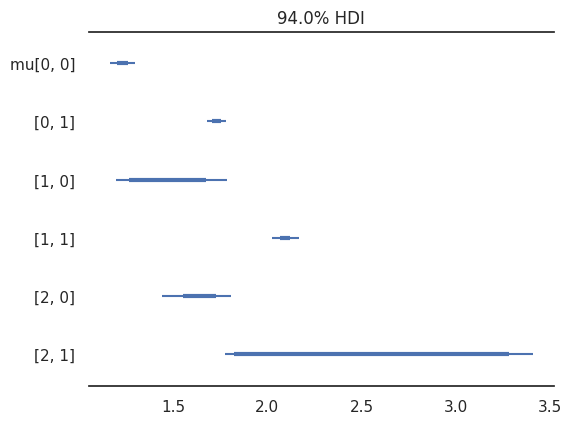

In [104]:
az.plot_forest(idata_path, var_names="mu");

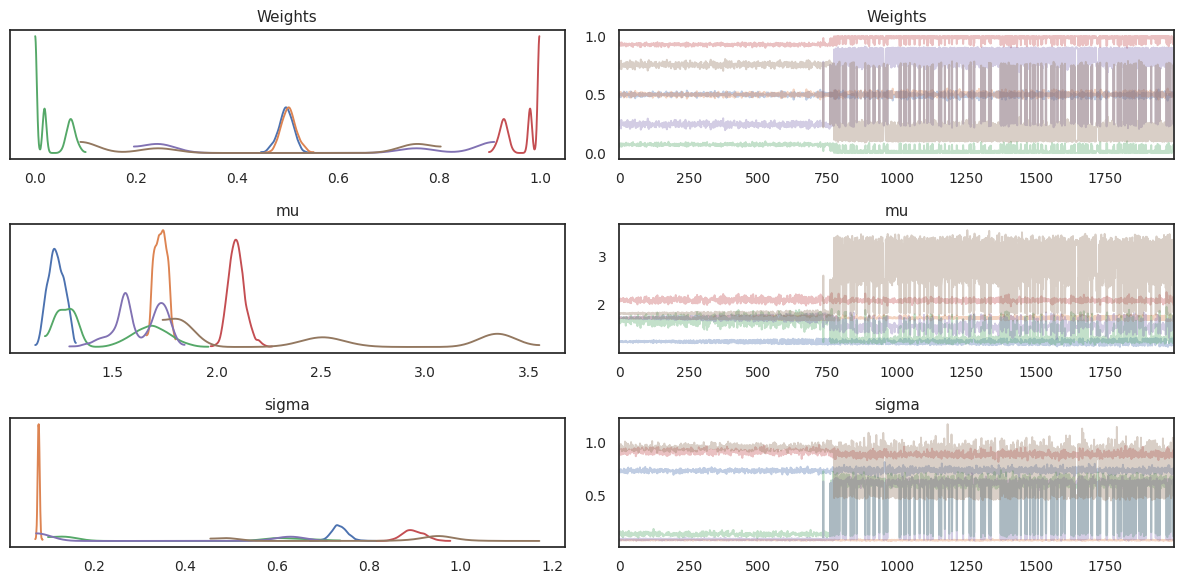

In [105]:
az.plot_trace(idata_path)
plt.tight_layout();

In [ ]:
from scipy.stats import norm
from xarray_einstats.stats import XrContinuousRV


In [ ]:
idata_path

In [ ]:
xi = np.linspace(0.1, 30, 500)
post = idata_path.posterior
pdf_components = XrContinuousRV(norm, post["mu"], post["sigma"]).pdf(xi) * post["Weights"]
pdf = pdf_components.sum("k")

fig, ax = plt.subplots(3, 1, figsize=(7, 8), sharex=True)
# empirical histogram
ax[0].hist(x, 50)
ax[0].set(title="Data", xlabel="x", ylabel="Frequency")
# pdf
pdf_components.mean(dim=["chain", "draw"]).sum("K").plot.line(ax=ax[1])
ax[1].set(title="PDF", xlabel="x", ylabel="Probability\ndensity")
# plot group membership probabilities
(pdf_components / pdf).mean(dim=["chain", "draw"]).plot.line(hue="K", ax=ax[2])
ax[2].set(title="Group membership", xlabel="x", ylabel="Probability");